In [75]:
import numpy as np # linear algebra
import pandas as pd # CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import warnings
from math import pi, sin, cos, sqrt, atan2, radians,asin
import calendar
from numpy.polynomial.polynomial import polyfit
import os # reading the input files we have access to
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [76]:
train=pd.read_csv("input/train.csv",nrows=1000000) #Has to be 10^6 for good performance [TODO]
print("Shape of Training Data",train.shape)
test=pd.read_csv("input/test.csv")
print("Shape of Testing Data", test.shape)

Shape of Training Data (1000000, 8)
Shape of Testing Data (9914, 7)


In [77]:
def distance(lat1,lon1,lat2,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))
def clean_data(data):
    boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}
    
    data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
    data['pickup_day']=data['pickup_datetime'].apply(lambda x:x.day)
    #data['pickup_sin_hm'] = data['pickup_datetime'].apply(lambda x:sin(2*pi*(x.hour * 60 + x.minute)/1440))
    #data['pickup_cos_hm'] = data['pickup_datetime'].apply(lambda x:cos(2*pi*(x.hour * 60 + x.minute)/1440))
    data['pickup_hour']=data['pickup_datetime'].apply(lambda x:x.hour)
    data['pickup_month']=data['pickup_datetime'].apply(lambda x:x.month)
    data['pickup_year']=data['pickup_datetime'].apply(lambda x:x.year)
    data['distance'] = data.apply(lambda x: distance(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)
    if 'fare_amount' in data.columns:
        data = data[data['fare_amount']>0]
        data = data[data['fare_amount']<=50]
        
    data.loc[~((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
        (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
        (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
        (data.dropoff_latitude >=boundary['min_lat']) & (data.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=1
    data.loc[((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
        (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
        (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
        (data.dropoff_latitude >=boundary['min_lat']) & (data.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=0

    # Let us drop rows, where location is outlier
    data=data.loc[data['is_outlier_loc']==0]
    data.drop(['is_outlier_loc'],axis=1,inplace=True)
    
    data=data[data['passenger_count']<=8]
    data['passenger_count'] = data['passenger_count'].apply(lambda x:1 if x > 4 else 0)
    
    weekday_names = {0: 'Monday',
                 1: 'Tuesday',
                 2: 'Wednesday',
                 3: 'Thursday',
                 4: 'Friday',
                 5: 'Saturday',
                 6: 'Sunday'}
    data = data.join(pd.get_dummies("is"+data['pickup_datetime'].dt.weekday.apply(lambda x: weekday_names.get(x))))
    #^one-hot encoding of weekday
    return data

In [78]:
train=clean_data(train)
test=clean_data(test)

In [79]:
train.describe()
#test.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_month,pickup_year,distance,isFriday,isMonday,isSaturday,isSunday,isThursday,isTuesday,isWednesday
count,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000,966615.000000
mean,10.699657,-73.976138,40.751679,-73.974630,40.751902,0.091774,15.692906,13.514632,6.265289,2011.721878,1.955092,0.154312,0.128401,0.151665,0.130983,0.149707,0.140092,0.144841
std,7.721215,0.035513,0.028453,0.034297,0.031632,0.288707,8.683856,6.516406,3.437368,1.861344,2.062300,0.361247,0.334536,0.358696,0.337382,0.356784,0.347083,0.351940
min,0.010000,-74.262970,40.575871,-74.254837,40.573200,0.000000,1.000000,0.000000,1.000000,2009.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992318,40.736930,-73.991548,40.736095,0.000000,8.000000,9.000000,3.000000,2010.000000,0.775138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.500000,-73.982144,40.753605,-73.980624,40.754055,0.000000,16.000000,14.000000,6.000000,2012.000000,1.323132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.500000,-73.968635,40.767706,-73.965600,40.768488,0.000000,23.000000,19.000000,9.000000,2013.000000,2.375195,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,50.000000,-73.089387,41.696852,-73.110500,41.646975,1.000000,31.000000,23.000000,12.000000,2015.000000,68.868482,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [80]:
def processDataForModelling(data,target,drop_cols,is_train=True,split=0.25):
    data_1=data.drop(drop_cols,axis=1)
    if is_train==True:
        X=data_1.drop([target],axis=1)
        y=data_1[target]
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=split,random_state=123)
        
        print("Shape of Training Features",X_train.shape)
        print("Shape of Validation Features ",X_test.shape)
        
        return X_train, X_test, y_train, y_test
    else:
        print ("Shape of Test Data",data_1.shape)
        return data_1

In [81]:
X_train, X_test, y_train, y_test=processDataForModelling(train,'fare_amount',drop_cols=['key','pickup_datetime'],is_train=True,split=0.2)

Shape of Training Features (773292, 17)
Shape of Validation Features  (193323, 17)


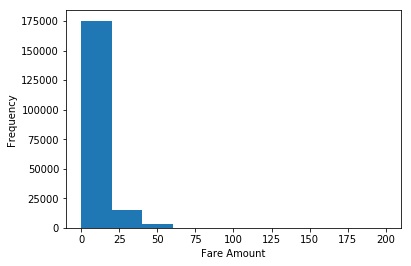

In [82]:
#fig, ax = plt.subplots()
#y_test.value_counts().plot(ax=ax, kind='bar')
#plt.hist(y_test, bins='auto')
plt.hist(y_test, bins=[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200])
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
fig = plt.gcf()
fig.savefig('fare-amount-distribution2.png')
plt.show()

In [83]:
test_data=processDataForModelling(test,'fare_amount',drop_cols=['key','pickup_datetime'],is_train=False)

Shape of Test Data (9913, 17)


In [84]:
avg_fare=round(np.mean(y_train),2)
baseline_pred=np.repeat(avg_fare,y_test.shape[0])
baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, y_test))
baseline_mape = np.mean(np.abs((y_test - baseline_pred)/y_test)) * 100
print("Basline RMSE of Validation data :",baseline_rmse)
print("Basline MAPE of Validation data :",baseline_mape)

Basline RMSE of Validation data : 7.697757622386423
Basline MAPE of Validation data : 60.468202999298605


In [85]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=np.round(lm.predict(X_test),2)
lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
lm_mape = np.mean(np.abs((y_test - y_pred)/y_test)) * 100
print("RMSE for Linear Regression is ",lm_rmse)
print("MAPE for Linear Regression is:", lm_mape)

RMSE for Linear Regression is  4.240823415995558
MAPE for Linear Regression is: 25.14133268583712


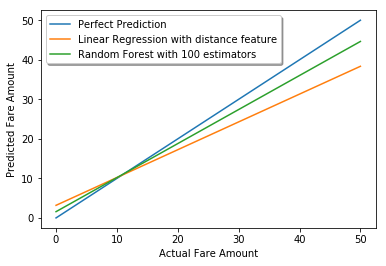

In [87]:
#print(y_pred.shape)
#print(y_test.shape)
x = list(y_test)
y_list = list(y_pred)
y2_list = list(rf_pred)
#print(x)
fig, ax = plt.subplots()
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], label='Perfect Prediction')
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y_list, 1))(np.unique(x)), label='Linear Regression with distance feature')
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y2_list, 1))(np.unique(x)), label='Random Forest with 100 estimators')
legend = ax.legend(loc='upper left', shadow=True)
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
fig = plt.gcf()
fig.savefig('accuracy-comparison.png')
plt.show()

In [86]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 1,n_jobs=-1, verbose=2)
rf.fit(X_train,y_train)
rf_pred= rf.predict(X_test)
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
rf_mape = np.mean(np.abs((y_test - rf_pred)/y_test)) * 100
print("RMSE for Random Forest is ",rf_rmse)
print("MAPE for Random Forest is ",rf_mape)
print(rf.feature_importances_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100building tree 5 of 100
building tree 6 of 100building tree 7 of 100building tree 8 of 100building tree 9 of 100
building tree 10 of 100

building tree 11 of 100
building tree 12 of 100building tree 13 of 100
building tree 14 of 100building tree 15 of 100
building tree 16 of 100building tree 17 of 100building tree 18 of 100



building tree 19 of 100building tree 20 of 100
building tree 21 of 100
building tree 22 of 100





building tree 23 of 100



building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.3min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    2.9s finished


RMSE for Random Forest is  2.8656269766343545
MAPE for Random Forest is  18.104558558553535
[0.03051665 0.0229748  0.03258211 0.03219019 0.00147621 0.01275877
 0.01575397 0.01102682 0.02736695 0.80147584 0.00164509 0.00157848
 0.00189936 0.00193522 0.00165744 0.00152642 0.00163567]


In [15]:
def pltRmse(n):
    rf = RandomForestRegressor(n_estimators = n, random_state = 1,n_jobs=-1, verbose=2)
    rf.fit(X_train,y_train)
    rf_pred= rf.predict(X_test)
    rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
    print(n)
    print("RMSE for Random Forest is ",rf_rmse)
    return rf_rmse
    #print(rf.feature_importances_)
A = [1, 2, 3, 4, 5, 6, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
B = list(map(lambda x : pltRmse(x), A))
print(A)
print(B)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 1


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   22.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


1
RMSE for Random Forest is  5.549232683034081


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 2
building tree 2 of 2


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   20.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.3s finished


2
RMSE for Random Forest is  4.845694775662842


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 3
building tree 2 of 3
building tree 3 of 3


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s finished


3
RMSE for Random Forest is  4.566965885649315


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 4building tree 2 of 4

building tree 3 of 4
building tree 4 of 4


[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   22.8s remaining:   22.8s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   23.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


4
RMSE for Random Forest is  4.384056457769695


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 5building tree 2 of 5
building tree 3 of 5

building tree 4 of 5building tree 5 of 5



[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   24.2s remaining:   16.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.7s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.4s finished


5
RMSE for Random Forest is  4.286975915289767
building tree 1 of 6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 2 of 6
building tree 3 of 6
building tree 4 of 6
building tree 5 of 6
building tree 6 of 6


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   23.8s remaining:   23.8s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   25.0s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of   6 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=6)]: Done   6 out of   6 | elapsed:    0.3s finished


6
RMSE for Random Forest is  4.2127454168939025


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10building tree 4 of 10building tree 5 of 10
building tree 6 of 10

building tree 7 of 10
building tree 8 of 10building tree 9 of 10

building tree 10 of 10



[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   25.7s remaining:   25.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   27.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.4s finished


10
RMSE for Random Forest is  4.066950785738259
building tree 1 of 20
building tree 2 of 20
building tree 3 of 20building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20building tree 13 of 20
building tree 14 of 20


building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:   37.1s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   41.1s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   42.0s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:    0.3s remaining:    1.7s
[Parallel(n_jobs=20)]: Done  14 out of  20 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    0.8s finished


20
RMSE for Random Forest is  3.9540803291402433


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30building tree 17 of 30
building tree 18 of 30

building tree 19 of 30
building tree 20 of 30
building tree 21 of 30building tree 22 of 30building tree 23 of 30


building tree 24 of 30

building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   47.7s remaining:   47.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  15 out of  30 | elapsed:    1.0s remaining:    1.0s
[Parallel(n_jobs=24)]: Done  30 out of  30 | elapsed:    1.2s finished


30
RMSE for Random Forest is  3.936414137767052


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 40building tree 2 of 40
building tree 3 of 40
building tree 4 of 40
building tree 5 of 40
building tree 6 of 40
building tree 7 of 40
building tree 8 of 40building tree 9 of 40
building tree 10 of 40
building tree 11 of 40building tree 12 of 40
building tree 13 of 40
building tree 14 of 40

building tree 15 of 40
building tree 16 of 40
building tree 17 of 40
building tree 18 of 40
building tree 19 of 40building tree 20 of 40
building tree 21 of 40

building tree 22 of 40

building tree 23 of 40
building tree 24 of 40



[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   39.8s


building tree 25 of 40
building tree 26 of 40
building tree 27 of 40
building tree 28 of 40
building tree 29 of 40
building tree 30 of 40
building tree 31 of 40
building tree 32 of 40
building tree 33 of 40
building tree 34 of 40
building tree 35 of 40
building tree 36 of 40
building tree 37 of 40
building tree 38 of 40

[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:   47.6s remaining:  1.5min



building tree 39 of 40
building tree 40 of 40


[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  1.4min remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.4min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=24)]: Done  14 out of  40 | elapsed:    0.9s remaining:    1.6s
[Parallel(n_jobs=24)]: Done  35 out of  40 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=24)]: Done  40 out of  40 | elapsed:    1.4s finished


40
RMSE for Random Forest is  3.9152112126156426


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 50building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50building tree 12 of 50

building tree 13 of 50
building tree 14 of 50
building tree 15 of 50building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50


building tree 22 of 50building tree 23 of 50
building tree 24 of 50

building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:  1.4min remaining:   59.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  29 out of  50 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=24)]: Done  50 out of  50 | elapsed:    1.9s finished


50
RMSE for Random Forest is  3.9021038028182886


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 60building tree 2 of 60
building tree 3 of 60
building tree 4 of 60

building tree 5 of 60
building tree 6 of 60building tree 7 of 60building tree 8 of 60
building tree 9 of 60
building tree 10 of 60building tree 11 of 60
building tree 12 of 60
building tree 13 of 60
building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60

building tree 20 of 60
building tree 21 of 60
building tree 22 of 60

building tree 23 of 60

building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60
building tree 28 of 60
building tree 29 of 60
building tree 30 of 60
building tree 31 of 60
building tree 32 of 60
building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60
building tree 39 of 60
building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:  1.5min remaining:   32.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.0min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  44 out of  60 | elapsed:    1.8s remaining:    0.7s
[Parallel(n_jobs=24)]: Done  60 out of  60 | elapsed:    2.0s finished


60
RMSE for Random Forest is  3.8904691463164176


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 70
building tree 2 of 70
building tree 3 of 70
building tree 4 of 70
building tree 5 of 70building tree 6 of 70
building tree 7 of 70
building tree 8 of 70
building tree 9 of 70building tree 10 of 70
building tree 11 of 70

building tree 12 of 70
building tree 13 of 70
building tree 14 of 70
building tree 15 of 70
building tree 16 of 70
building tree 17 of 70
building tree 18 of 70
building tree 19 of 70

building tree 20 of 70
building tree 21 of 70
building tree 22 of 70
building tree 23 of 70
building tree 24 of 70
building tree 25 of 70
building tree 26 of 70
building tree 27 of 70
building tree 28 of 70
building tree 29 of 70
building tree 30 of 70
building tree 31 of 70
building tree 32 of 70
building tree 33 of 70
building tree 34 of 70
building tree 35 of 70
building tree 36 of 70
building tree 37 of 70
building tree 38 of 70building tree 39 of 70

building tree 40 of 70
building tree 41 of 70
building tree 42 of 70
building tree 43 of 70
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  59 out of  70 | elapsed:  2.2min remaining:   24.5s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.3min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  59 out of  70 | elapsed:    1.8s remaining:    0.3s
[Parallel(n_jobs=24)]: Done  70 out of  70 | elapsed:    2.1s finished


70
RMSE for Random Forest is  3.8848208546964047


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 80
building tree 2 of 80
building tree 3 of 80
building tree 4 of 80
building tree 5 of 80
building tree 6 of 80
building tree 7 of 80
building tree 8 of 80
building tree 9 of 80building tree 10 of 80
building tree 11 of 80
building tree 12 of 80
building tree 13 of 80
building tree 14 of 80

building tree 15 of 80
building tree 16 of 80
building tree 17 of 80
building tree 18 of 80
building tree 19 of 80
building tree 20 of 80
building tree 21 of 80
building tree 22 of 80
building tree 23 of 80
building tree 24 of 80
building tree 25 of 80
building tree 26 of 80
building tree 27 of 80
building tree 28 of 80
building tree 29 of 80
building tree 30 of 80
building tree 31 of 80
building tree 32 of 80
building tree 33 of 80
building tree 34 of 80
building tree 35 of 80
building tree 36 of 80
building tree 37 of 80
building tree 38 of 80
building tree 39 of 80
building tree 40 of 80
building tree 41 of 80
building tree 42 of 80
building tree 43 of 80
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  74 out of  80 | elapsed:  5.7min remaining:   27.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  5.9min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  74 out of  80 | elapsed:    2.8s remaining:    0.2s
[Parallel(n_jobs=24)]: Done  80 out of  80 | elapsed:    3.0s finished


80
RMSE for Random Forest is  3.8836149989122397


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 90building tree 2 of 90
building tree 3 of 90
building tree 4 of 90
building tree 5 of 90
building tree 6 of 90
building tree 7 of 90building tree 8 of 90
building tree 9 of 90
building tree 10 of 90

building tree 11 of 90
building tree 12 of 90
building tree 13 of 90
building tree 14 of 90
building tree 15 of 90
building tree 16 of 90
building tree 17 of 90
building tree 18 of 90building tree 19 of 90


building tree 20 of 90
building tree 21 of 90
building tree 22 of 90building tree 23 of 90

building tree 24 of 90
building tree 25 of 90
building tree 26 of 90
building tree 27 of 90
building tree 28 of 90
building tree 29 of 90
building tree 30 of 90
building tree 31 of 90
building tree 32 of 90
building tree 33 of 90
building tree 34 of 90
building tree 35 of 90
building tree 36 of 90
building tree 37 of 90
building tree 38 of 90
building tree 39 of 90
building tree 40 of 90
building tree 41 of 90
building tree 42 of 90
building tree 43 of 90
building tree 44 of 

[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.7min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  90 out of  90 | elapsed:    3.0s finished


90
RMSE for Random Forest is  3.8804387286359194


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100

building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100building tree 39 of 100

building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done 100 out of 100 | elapsed:    2.8s finished


100
RMSE for Random Forest is  3.8777722919097095
[1, 2, 3, 4, 5, 6, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[5.549232683034081, 4.845694775662842, 4.566965885649315, 4.384056457769695, 4.286975915289767, 4.2127454168939025, 4.066950785738259, 3.9540803291402433, 3.936414137767052, 3.9152112126156426, 3.9021038028182886, 3.8904691463164176, 3.8848208546964047, 3.8836149989122397, 3.8804387286359194, 3.8777722919097095]


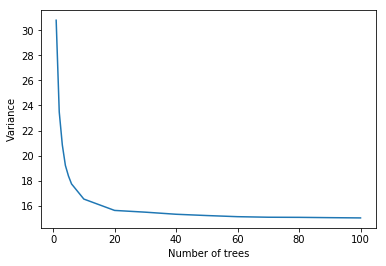

In [5]:
A = [1, 2, 3, 4, 5, 6, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
B = [5.549232683034081, 4.845694775662842, 4.566965885649315, 4.384056457769695, 4.286975915289767, 4.2127454168939025, 4.066950785738259, 3.9540803291402433, 3.936414137767052, 3.9152112126156426, 3.9021038028182886, 3.8904691463164176, 3.8848208546964047, 3.8836149989122397, 3.8804387286359194, 3.8777722919097095]
B = list(map(lambda x: x*x, B))
plt.plot(A, B)
plt.xlabel("Number of trees")
plt.ylabel("Variance")
fig = plt.gcf()
fig.savefig('tree-vs-variance.png')
plt.show()

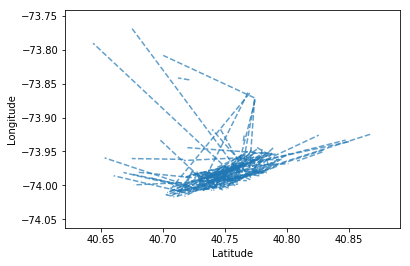

In [58]:
#lines = [[(0, 1), (1, 1)], [(2, 3), (3, 3)], [(1, 2), (1, 3)]]
lat1 = train['pickup_latitude'].tolist()
lat2 = train['dropoff_latitude'].tolist()
long1 = train['pickup_longitude'].tolist()
long2 = train['dropoff_longitude'].tolist()
src = list(zip(lat1, long1))
dest = list(zip(lat2, long2))
lines = list(map(lambda x,y:[x,y],src,dest))
#print(lines)
#lines = [(train['pickup_latitude'], train['pickup_longitude']), (train['dropoff_latitude'], train['dropoff_longitude'])]
lc = mc.LineCollection(lines, linestyle='--', alpha=0.7)
fig, ax = plt.subplots()
ax.add_collection(lc)
ax.autoscale()
ax.margins(0.1)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
fig.savefig('latitude-relationship.png')
plt.show()

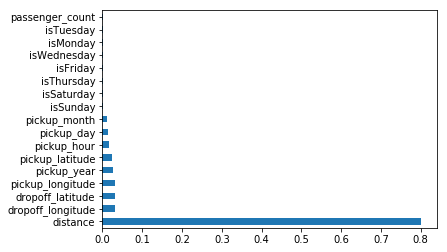

In [88]:
feat_importances = pd.Series(rf.feature_importances_, index=X_test.columns)
feat_importances.nlargest(17).plot(kind='barh')
fig = plt.gcf()
fig.savefig('feature-importance.png')
plt.show()